In [ ]:
# import split_folders
import glob
# import torch
# import numpy as np
# import torchvision
# from torchvision import datasets, models, transforms
# import matplotlib.pyplot as plt
# import time
# import os
# import copy

In [ ]:
input_folders='/exp/data/class17/dataset_score/'
# output='/exp/data/class10/dataset/'
output='/exp/data/emotion_data/dataset/'
# split_folders.ratio(input_folders,output,seed=1337,ratio=(.8,.2))


In [ ]:
lst=glob.glob(output+'train/*/*')
lsv=glob.glob(output+'val/*/*')

print(len(lst), len(lsv))
print(len(glob.glob(input_folders+'*val/*')))

In [ ]:
lsv

In [1]:
import mlflow
from tensorboardX import SummaryWriter
import tensorflow as tf
import tensorflow.summary
from tensorflow.summary import scalar
from tensorflow.summary import histogram
import mlflow.pytorch
import seaborn as sns
from datetime import date
today = str(date.today())

In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.2


In [3]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = '/exp/data/cross/S_17_17_CS/'
# data_dir='/exp/data/emotion_data/dataset/'

# Models to choose from [resnet, alexnet, vgg16, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 17

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for 
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

#use pretrained models
pre_trained=True

In [4]:
def log_scalar(name, value, step):
    """Log a scalar value to both MLflow and TensorBoard"""
#     writer.add_summary(scalar(name, value).eval(), step)
    mlflow.log_metric(name, value, step=step)

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase=='train':
                log_scalar('training_loss', epoch_loss, epoch)
                log_scalar('training_accuracy', float(epoch_acc), epoch)
            if phase=='val':
                log_scalar('val_loss', epoch_loss, epoch)
                log_scalar('val_accuracy', float(epoch_acc), epoch)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    mlflow.log_param('Training time',time_elapsed)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    mlflow.log_param('Best val Acc',float(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet201
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pre_trained)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [9]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

In [10]:
with mlflow.start_run() as run:
    mlflow.log_param('dataset', data_dir)
    mlflow.log_param('model name', model_name)
    mlflow.log_param('number of classes', num_classes)
    mlflow.log_param('Batch size', batch_size)
    mlflow.log_param('epochs', num_epochs)
    mlflow.log_param('feature extracted', feature_extract)
    mlflow.log_param('pre-trained', pre_trained)
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    mlflow.pytorch.log_model(model_ft,"models")
    mlflow.pytorch.save_model(model_ft,'/exp/data/models/'+today+'/')
    
#     mlflow.log_metric('history',hist)

Epoch 0/49
----------
train Loss: 2.2379 Acc: 0.2620
val Loss: 1.5277 Acc: 0.4597

Epoch 1/49
----------
train Loss: 1.6687 Acc: 0.4275
val Loss: 1.1878 Acc: 0.5754

Epoch 2/49
----------
train Loss: 1.4153 Acc: 0.5116
val Loss: 0.9767 Acc: 0.6515

Epoch 3/49
----------
train Loss: 1.2777 Acc: 0.5571
val Loss: 0.9806 Acc: 0.6605

Epoch 4/49
----------
train Loss: 1.1931 Acc: 0.5877
val Loss: 0.8695 Acc: 0.7029

Epoch 5/49
----------
train Loss: 1.1409 Acc: 0.6113
val Loss: 0.9568 Acc: 0.6654

Epoch 6/49
----------
train Loss: 1.0687 Acc: 0.6282
val Loss: 0.7810 Acc: 0.7191

Epoch 7/49
----------
train Loss: 1.0296 Acc: 0.6461
val Loss: 0.8213 Acc: 0.7197

Epoch 8/49
----------
train Loss: 1.0083 Acc: 0.6411
val Loss: 0.8316 Acc: 0.7212

Epoch 9/49
----------
train Loss: 0.9753 Acc: 0.6557
val Loss: 0.8789 Acc: 0.6780

Epoch 10/49
----------
train Loss: 0.9342 Acc: 0.6717
val Loss: 0.8241 Acc: 0.7168

Epoch 11/49
----------
train Loss: 0.9188 Acc: 0.6756
val Loss: 0.8471 Acc: 0.7078

Ep

In [12]:
torch.save(model_ft.state_dict(),'/exp/data/models/'+model_name+"/"+today+'.pth')

In [64]:
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1




In [65]:
import pandas as pd

classes=["A008","A009","A022","A023","A027","A028","A029","A031","A032","A033","A052","A041","A043","A045","A048","A050","A051"]
df_cm = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in classes],
                  columns = [i for i in classes])

In [66]:
df_cm=df_cm.astype(np.int64)

In [67]:
df_cm.to_csv("/exp/data/densenet_17_mat.csv")

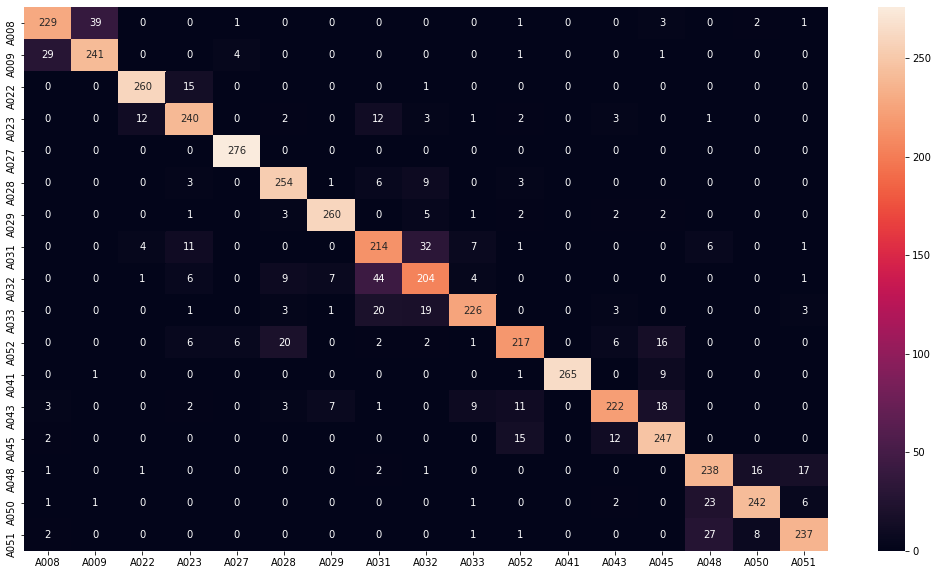

In [69]:
# plt.figure(figsize = (16,8)) 
f, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(df_cm,annot=True, fmt="d")